## Examples MODELS
- Black-Scholes: constant volatility
- Heston: stochastic volatility
- Signature SDEs: path-signature volatility

        +----------------------------+
        |    Black-Scholes Model     |
        |   dS_t = rS_t dt + σS_t dW |
        +----------------------------+
                    ↓
     +----------------------------------------+
     |           Heston Model                 |
     |  dS_t = rS_t dt + √v_t S_t dW_1        |
     |  dv_t = κ(θ - v_t)dt + ξ√v_t dW_2      |
     |  Corr(W_1, W_2) = ρ                    |
     +----------------------------------------+
(page 28-> 2nd paper)

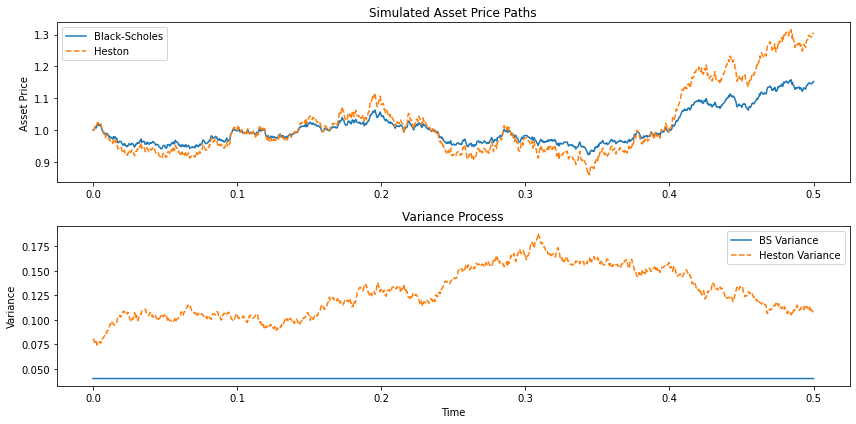

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === Parameters === #
T = 0.5         # Time horizon (1 year)
N = 1095         # Number of time steps (daily)
dt = T / N      # Time step
t = np.linspace(0, T, N)

S0 = 1        # Initial stock price
r = 0.0         # Risk-free rate
sigma_bs = 0.2  # Constant volatility for Black-Scholes

# Heston model parameters
v0 = 0.08       # Initial variance
kappa = 0.5     # Mean reversion speed
theta = 0.15    # Long-term variance
xi = 0.25        # Volatility of volatility
rho = -0.5      # Correlation between asset and volatility

# === Simulate paths === #
np.random.seed(42)
Z1 = np.random.normal(size=N)
Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=N)

# Black-Scholes path
S_bs = np.zeros(N)
S_bs[0] = S0
for i in range(1, N):
    S_bs[i] = S_bs[i-1] * np.exp((r - 0.5 * sigma_bs**2) * dt + sigma_bs * np.sqrt(dt) * Z1[i])

# Heston path
S_heston = np.zeros(N)
v_heston = np.zeros(N)
S_heston[0] = S0
v_heston[0] = v0

for i in range(1, N):
    # Ensure variance stays positive (Full Truncation Euler)
    v_heston[i] = np.abs(v_heston[i-1] + kappa*(theta - v_heston[i-1])*dt + xi*np.sqrt(v_heston[i-1])*np.sqrt(dt)*Z2[i])
    S_heston[i] = S_heston[i-1] * np.exp((r - 0.5 * v_heston[i-1])*dt + np.sqrt(v_heston[i-1])*np.sqrt(dt)*Z1[i])

# === Plot results === #
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, S_bs, label='Black-Scholes')
plt.plot(t, S_heston, label='Heston', linestyle='--')
plt.title('Simulated Asset Price Paths')
plt.ylabel('Asset Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, np.full(N, sigma_bs**2), label='BS Variance')
plt.plot(t, v_heston, label='Heston Variance', linestyle='--')
plt.title('Variance Process')
plt.ylabel('Variance')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()


### Theory to remember:
Variance= volatility^2
The volatility works like a standard deviation


## First easy example of path signature

In [7]:
pip install esig

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import esig.tosig as ts
np.random.seed(0)
two_dim_stream = np.random.random(size=(10,2)) #create a 2D path, sequence of 10 points in 2D space
sig= ts.stream2sig(two_dim_stream, 2) #compute the path signature up to level 2

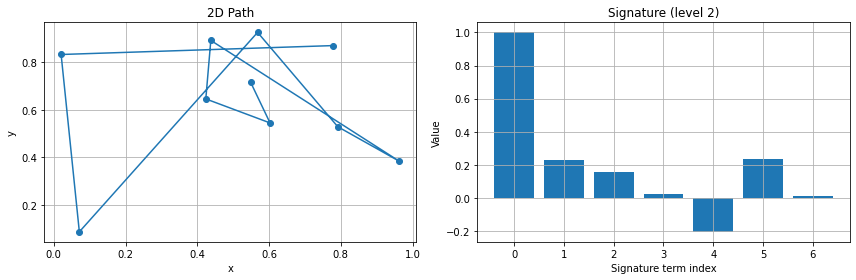

In [13]:
# Plot the path
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(two_dim_stream[:, 0], two_dim_stream[:, 1], marker='o')
plt.title("2D Path")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot the signature vector as a bar chart
plt.subplot(1, 2, 2)
plt.bar(range(len(sig)), sig)
plt.title("Signature (level 2)")
plt.xlabel("Signature term index")
plt.ylabel("Value")
plt.grid(True)

plt.tight_layout()
plt.show()

The left image is the randomly generated path (line in 2D), and the right image is the signature vector.

For instance, the signatures can be computed as follows: 

In [ ]:
import numpy as np
import esig.tosig as ts
X_1 = np.array([1., 3., 5., 8.]).reshape((-1,1))
X_2 = np.array([1., 4., 2., 6.]).reshape((-1,1))
two_dim_stream = np.append(X_1,X_2, axis=1)
signatures = ts.stream2sig(two_dim_stream, 3)
print(signatures)

This means: S^(1)=7, S^(2)=5, S^(1,1)=24.5, S^(1,2)=19, S^(2,1)=16, S^(2,2)=12.5

## Example path signature volatility model

In [14]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 1, 1)

# S&P 500 index data symbol on FRED is 'SP500'
data = web.DataReader('SP500', 'fred', start, end)

print(data.head())


              SP500
DATE               
2022-01-03  4796.56
2022-01-04  4793.54
2022-01-05  4700.58
2022-01-06  4696.05
2022-01-07  4677.03


In [16]:
import numpy as np
import pandas as pd

prices = data['SP500'].dropna()
log_returns = np.log(prices).diff().dropna()
window = 20  # e.g. 20 trading days ~ 1 month

realized_vol = log_returns.rolling(window=window).std().dropna()


In [17]:
print(f"log_returns length: {len(log_returns)}")
print(f"realized_vol length: {len(realized_vol)}")

print(log_returns.index[:5])
print(realized_vol.index[:5])


log_returns length: 250
realized_vol length: 231
DatetimeIndex(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10'],
              dtype='datetime64[ns]', name='DATE', freq=None)
DatetimeIndex(['2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04',
               '2022-02-07'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [18]:
import numpy as np
import iisignature

# First, ensure your Series have proper datetime indices:
log_returns = log_returns.dropna()
realized_vol = realized_vol.dropna()

# Align on intersection of their datetime indices:
common_dates = log_returns.index.intersection(realized_vol.index)

# Subset both series:
log_returns_aligned = log_returns.loc[common_dates]
realized_vol_aligned = realized_vol.loc[common_dates]

depth = 3
path_dim = 2

X = []
y = []

for i in range(window, len(common_dates)):
    # Extract window of returns using loc by date, based on position i
    date = common_dates[i]
    window_dates = common_dates[i - window:i]

    returns_window = log_returns_aligned.loc[window_dates].values
    returns_window = (returns_window - returns_window.mean()) / returns_window.std()  # normalize
    squared_returns = returns_window ** 2
    time_axis = np.linspace(0, 1, window)
    
    path = np.column_stack((time_axis, returns_window, squared_returns))
    sig = iisignature.sig(path, depth)
    X.append(sig)
    
    y.append(realized_vol_aligned.loc[date])

X = np.array(X)
y = np.array(y)

In [19]:
# === Step 5: Split data, scale target, and train model ===
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === Scale features and target ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# === Ridge regression with cross-validated alpha ===
alphas = np.logspace(-3, 3, 30)
model = RidgeCV(alphas=alphas, cv=5)
model.fit(X_train, y_train)

# === Predictions ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.6f}")


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


RMSE: 0.002325
R2: 0.361836


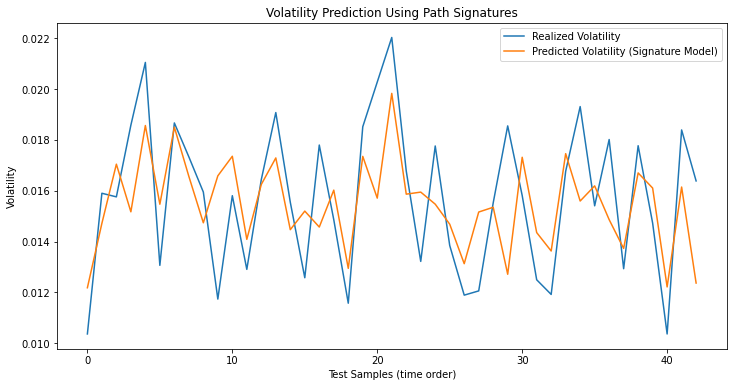

In [20]:
# === Step 6: Plot results and print metrics ===
plt.figure(figsize=(12,6))
plt.plot(y_test_orig, label='Realized Volatility')
plt.plot(y_pred, label='Predicted Volatility (Signature Model)')
plt.legend()
plt.title('Volatility Prediction Using Path Signatures')
plt.xlabel('Test Samples (time order)')
plt.ylabel('Volatility')
plt.show()


Understanding behind this:
- Data Preparation:
You collect daily prices and compute log returns: these measure the percentage change in price from one day to the next.
You calculate realized volatility as the rolling standard deviation of these log returns over a window (e.g., 20 days). This serves as your “true” volatility target.

- Path Signatures:
Instead of just looking at raw returns, you represent the recent price movement as a path in time-return space.
You add time as one coordinate, so your path is a sequence of points like (time, return, return²).
You then compute the signature of this path — a mathematical summary capturing complex patterns and order of movements, inspired by rough path theory.

- Regression Model (Ridge):
Using these signature features, you fit a Ridge regression to predict the realized volatility at the next time step.
Ridge adds regularization to avoid overfitting because signatures can be high-dimensional.
You also scale features and targets to improve learning.

- Prediction and Evaluation:
After training, the model predicts volatility on unseen data.
You evaluate the model with metrics like RMSE and R².
The smoother predicted volatility results from the model capturing general trends in the price paths, but not every short-term jump.

#### Ridge regression:
https://www.ibm.com/think/topics/ridge-regression

Ridge regression is a statistical regularization technique. It corrects for overfitting on training data in machine learning models. Is one of several types of regularization for linear regression models. Regularization is a statistical method to reduce errors caused by overfitting on training data.


### Meeting 09/10

In [2]:
pip install iisignature


Note: you may need to restart the kernel to use updated packages.


Signature dimension (depth=3): 3
Shapes: X=(950, 3), y=(950,)


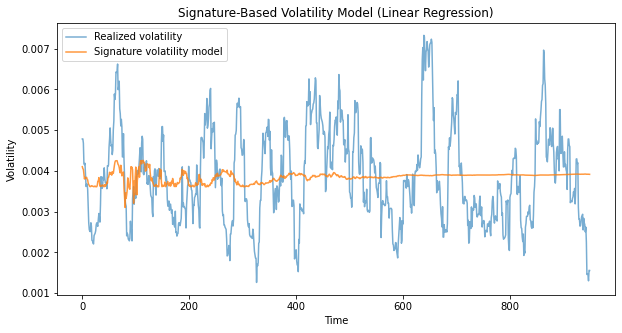

RMSE: 0.001154
R2: 0.012259


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import iisignature as iisig
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1. Generate synthetic data
# --------------------------
np.random.seed(0)
T = 1000
dt = 1 / 252
returns = np.sqrt(dt) * np.random.randn(T)
price = 100 * np.exp(np.cumsum(returns))

# Realized volatility proxy
vol_realized = pd.Series(returns**2).rolling(20).mean()

# --------------------------
# 2. Compute path signatures
# --------------------------
depth = 3
sig_dim = iisig.siglength(1, depth)
print(f"Signature dimension (depth={depth}):", sig_dim)

window = 50
signatures = []
valid_indices = []

for i in range(window, len(price)):
    path_segment = np.array(price[i - window:i]).reshape(-1, 1)
    sig = iisig.sig(path_segment, depth)
    signatures.append(sig)
    valid_indices.append(i)  # keep track of the time index

X = np.vstack(signatures)

# Align y (drop NaNs, and use matching indices)
vol_realized = vol_realized.iloc[valid_indices].dropna()
# Match X to y
X = X[-len(vol_realized):]
y = vol_realized.values

print(f"Shapes: X={X.shape}, y={y.shape}")

# --------------------------
# 3. Fit Linear Regression
# --------------------------
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# --------------------------
# 4. Plot results
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(y, label="Realized volatility", alpha=0.6)
plt.plot(y_pred, label="Signature volatility model", alpha=0.8)
plt.legend()
plt.title("Signature-Based Volatility Model (Linear Regression)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()
# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.6f}")


              SP500
DATE               
2022-01-03  4796.56
2022-01-04  4793.54
2022-01-05  4700.58
2022-01-06  4696.05
2022-01-07  4677.03
Feature matrix shape: (451, 4)


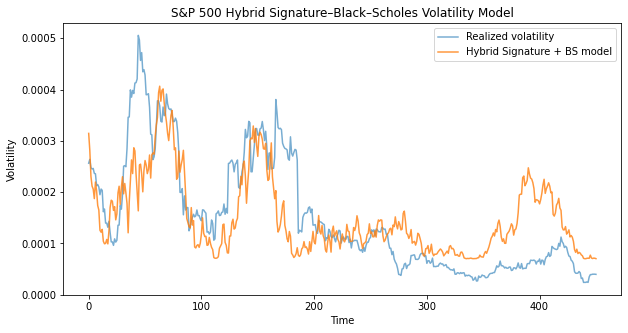

RMSE: 0.000082
R2: 0.455505


In [7]:
import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import iisignature as iisig
from scipy.stats import norm

# -----------------------
# Download S&P500 daily data
# -----------------------
start = datetime.datetime(2022, 1, 1)
end   = datetime.datetime(2024, 1, 1)

data = web.DataReader('SP500', 'fred', start, end)
data = data.dropna()
data.columns = ['SP500']
print(data.head())

price = data['SP500'].values
dates = data.index

# -----------------------
# Compute returns and realized volatility
# -----------------------
returns = np.diff(np.log(price))
returns = np.insert(returns, 0, 0)
window_realized = 20
vol_realized = pd.Series(returns**2).rolling(window_realized).mean()

# Black–Scholes call price function
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Parameters (example)
r = 0.01       # risk-free rate
K = np.mean(price)  # at-the-money
T_maturity = 0.50   # 6 months
sigma_base = 0.2

# Generate synthetic option prices
C = bs_call_price(price, K, T_maturity, r, sigma_base)

# Compute synthetic implied vols (they’ll be close to sigma_base)
def implied_volatility(C, S, K, T, r):
    sigma = 0.2
    for _ in range(50):
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        sigma -= (price - C) / max(vega, 1e-6)
        sigma = max(sigma, 1e-6)
    return sigma

vol_bs = np.array([implied_volatility(c, s, K, T_maturity, r)
                   for c, s in zip(C, price)])
depth = 3
sig_dim = iisig.siglength(1, depth)
window_sig = 50

signatures = []
indices = []

for i in range(window_sig, len(price)):
    path_segment = np.array(price[i - window_sig:i]).reshape(-1, 1)
    sig = iisig.sig(path_segment, depth)
    signatures.append(sig)
    indices.append(i)

X_sig = np.vstack(signatures)

# Align volatility series
vol_realized = vol_realized.iloc[indices].dropna()
vol_bs_aligned = vol_bs[indices[-len(vol_realized):]]

# Trim signatures to match y length
X_sig = X_sig[-len(vol_realized):]
y = vol_realized.values

# Combine features: signatures + Black–Scholes vol
X_combined = np.column_stack([X_sig, vol_bs_aligned])
print("Feature matrix shape:", X_combined.shape)

model = LinearRegression()
model.fit(X_combined, y)
y_pred = model.predict(X_combined)

plt.figure(figsize=(10, 5))
plt.plot(y, label="Realized volatility", alpha=0.6)
plt.plot(y_pred, label="Hybrid Signature + BS model", alpha=0.8)
plt.title("S&P 500 Hybrid Signature–Black–Scholes Volatility Model")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# === Metrics ===
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.6f}")

## Explanation of the code:
In latex, marta's notes.

Downloaded data from 2023-01-01 to 2025-01-01
              SP500
DATE               
2023-01-03  3824.14
2023-01-04  3852.97
2023-01-05  3808.10
2023-01-06  3895.08
2023-01-09  3892.09
Feature matrix shape: (452, 4)


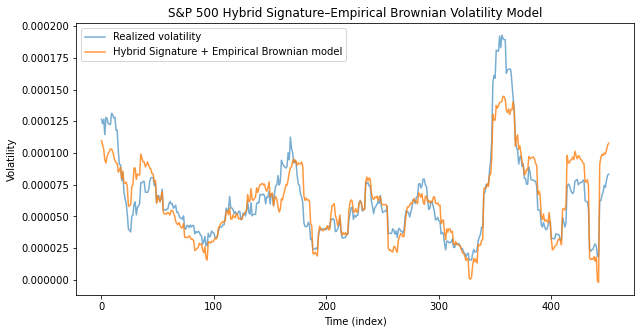

RMSE: 0.000015
R2: 0.804908
0.0015348471168082681
0.00471360921943246


In [17]:
# =========================================================
# Hybrid Signature–Empirical Brownian Volatility Model
# =========================================================

import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import iisignature as iisig

# ---------------------------------------------------------
# 1. Download S&P500 daily data
# ---------------------------------------------------------
start = datetime.datetime(2023, 1, 1)
end   = datetime.datetime(2025, 1, 1)

data = web.DataReader('SP500', 'fred', start, end)
data = data.dropna()
data.columns = ['SP500']
print("Downloaded data from", start.date(), "to", end.date())
print(data.head())

price = data['SP500'].values
dates = data.index

# ---------------------------------------------------------
# 2. Compute returns and realized volatility
# ---------------------------------------------------------
returns = np.diff(np.log(price))
returns = np.insert(returns, 0, 0)
window_realized = 20
vol_realized = pd.Series(returns**2).rolling(window_realized).mean()

# ---------------------------------------------------------
# 3. Generate data-driven Brownian volatility
# ---------------------------------------------------------
# Scale synthetic Brownian noise to actual market volatility
np.random.seed(42)

# Estimate baseline volatility level from returns
sigma_empirical = np.std(returns)
scale_factor = 0.5   # controls how strong the Brownian component is

# Scale volatility to local market activity
vol_bm = pd.Series(np.abs(returns)).rolling(20).std().fillna(0).values

# ---------------------------------------------------------
# 4. Compute path signatures from price paths
# ---------------------------------------------------------
depth = 3
sig_dim = iisig.siglength(1, depth)
window_sig = 50

signatures = []
indices = []

for i in range(window_sig, len(price)):
    path_segment = np.array(price[i - window_sig:i]).reshape(-1, 1)
    sig = iisig.sig(path_segment, depth)
    signatures.append(sig)
    indices.append(i)

X_sig = np.vstack(signatures)

# ---------------------------------------------------------
# 5. Align data lengths
# ---------------------------------------------------------
vol_realized = vol_realized.iloc[indices].dropna()
vol_bm_aligned = vol_bm[indices[-len(vol_realized):]]

X_sig = X_sig[-len(vol_realized):]
y = vol_realized.values

# ---------------------------------------------------------
# 6. Combine features: Signatures + Brownian volatility
# ---------------------------------------------------------
X_combined = np.column_stack([X_sig, vol_bm_aligned])
print("Feature matrix shape:", X_combined.shape)

# ---------------------------------------------------------
# 7. Train Linear Regression model
# ---------------------------------------------------------
model = LinearRegression()
model.fit(X_combined, y)
y_pred = model.predict(X_combined)

# ---------------------------------------------------------
# 8. Plot results
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(y, label="Realized volatility", alpha=0.6)
plt.plot(y_pred, label="Hybrid Signature + Empirical Brownian model", alpha=0.8)
plt.title("S&P 500 Hybrid Signature–Empirical Brownian Volatility Model")
plt.xlabel("Time (index)")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 9. Evaluation metrics
# ---------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.6f}")
print(np.std(vol_bm))
print(np.mean(vol_bm))